In [1]:
import logging
from matplotlib import pyplot as plt

from src.common.globals import G
from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = G.processed_daily_full_dir

config = {
    'AV': {
        'key': '',
        'ticker': 'VGT',
    },
    'data': {
        'test_size': 0.05,
    },
    'model': {
        'name': 'VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30',
        'type': 'trend',
        'trend_prediction_window': 20,
    }
    ,
}

2023-11-19 06:12:45.925223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 06:12:45.925342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 06:12:45.925576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 06:12:45.977558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], logger=logger, directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
df = FE.create_slope_column(df, logger, slope_window=config['model']['trend_prediction_window'])
df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)
price = df_test['Adj Close']

_, df_test, y_column = TFDataPrep(config=config).choose_y(df_train, df_test, logger)

df_test_X = df_test.drop(columns=[y_column])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test[y_column]

#------------------------Load the model if necessary--------------------------
model_scaler_name = config['model']['name']

model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)

2023-11-19 06:12:48 - get_data - INFO - Loaded "../P7-Trading-Bot/data/03_processed/daily_full". Number data points 4965. From "2004-01-30 00:00:00" to "2023-10-19 00:00:00"
2023-11-19 06:12:48 - build_features - INFO - --------------------create_features() - shift(-1)--------------------
2023-11-19 06:12:48 - build_features - INFO - df.shape: (4964, 5)
2023-11-19 06:12:48 - build_features - INFO - df.columns: Index(['Open', 'Adj Close', 'Volume', 'high-low variance', 'Tomorrow'], dtype='object')


2023-11-19 06:12:51 - build_features - INFO - --------------------FE.create_slope_column()--------------------
2023-11-19 06:12:51 - build_features - INFO - df.shape: (4945, 6)
2023-11-19 06:12:51 - build_features - INFO - df.columns: Index(['Open', 'Adj Close', 'Volume', 'high-low variance', 'Tomorrow',
       'slope_20'],
      dtype='object')
2023-11-19 06:12:51 - models_service - INFO - df_train.shape: (4698, 6), df_test.shape: (247, 6)
2023-11-19 06:12:51 - models_service - INFO - Last record in df_train:
Open                 3.215500e+02
Adj Close            3.149712e+02
Volume               2.315876e+06
high-low variance    2.963769e+00
Tomorrow             3.186156e+02
slope_20            -1.813974e-01
Name: 2022-09-27 00:00:00, dtype: float64
2023-11-19 06:12:51 - models_service - INFO - Last record in df_test:
Open                    417.090000
Adj Close               413.158837
Volume               599944.000000
high-low variance         1.177204
Tomorrow                414.

In [3]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers_X,
                                        verbose=False)


# V.plot_series(  x=(df_test_y.index, df_test_y.index[window_size-1:]), 
#                 y=(df_test_y, results),
#                 model_name=model._name,
#                 signal = True,
#                 title=f'Predictions {model._name}',
#                 xlabel='Date',
#                 ylabel='Price',
#                 legend=['Actual', 'Predicted'],
#                 show=True)

     11/Unknown - 1s 5ms/step  

2023-11-19 06:12:54.184234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


228/228 [==============================] - 2s 6ms/step


2023-11-19 06:12:55.701710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5964879461929391463


12
12
12
[7, 27, 47, 67, 87, 107, 127, 147, 167, 187, 207, 227]


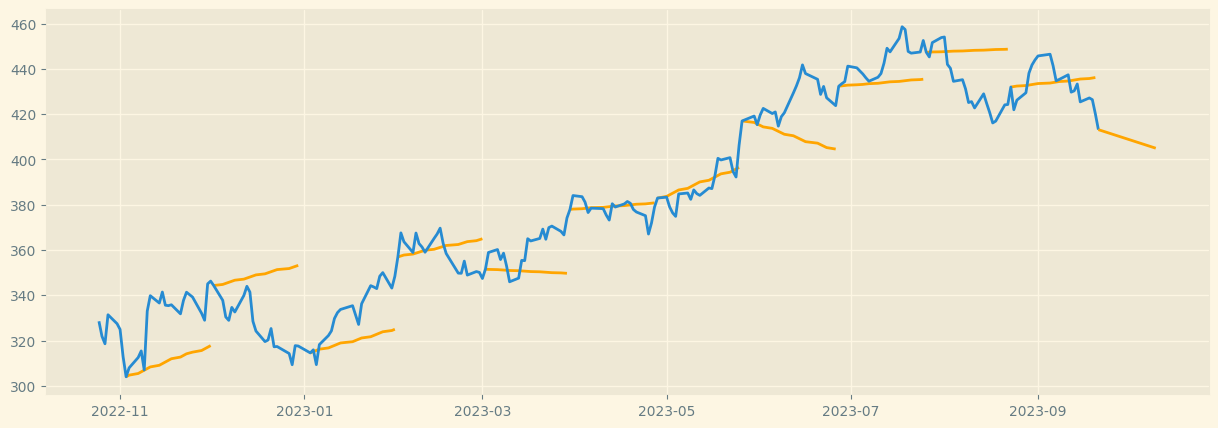

In [69]:
# get list of every 20th element of results and price but with last element included
results_adjusted = results[::-20][::-1]
price_adjusted = price[window_size-1:][::-20][::-1]

time_positions = [i for i in range(len(df_test_y.index[window_size-1:]))]
time_positions_adjusted = time_positions[::-20][::-1]

time_index = df_test_y.index[window_size-1:]

print(len(results_adjusted))
print(len(price_adjusted))
print(len(time_positions_adjusted))

print(time_positions_adjusted)

import numpy as np
import pandas as pd

def slopes(results_time_price_adjusted, time_index):
    slopes_values = []
    for i, (slope, tpa, price_) in enumerate(zip(*results_time_price_adjusted)):
        if i == len(results_time_price_adjusted[0])-1:
            break

        
        # Generate x values   
        x = np.linspace(tpa, results_time_price_adjusted[1][i+1]-1, 20)

        # Calculate b
        b = price_ - slope*tpa


        # Calculate corresponding y values
        y = slope*x + b

        # convert time positions x values to time index
        for inx, time_index_value in enumerate(time_index):
            if inx == tpa:
                x = time_index[inx: inx+20]
        
        slopes_values.append((x, y))

    return slopes_values

slopes_values = slopes((results_adjusted, time_positions_adjusted, price_adjusted), time_index)

# plot slopes
for i in range(len(slopes_values)):
    plt.plot(slopes_values[i][0], slopes_values[i][1], color='orange')
    
# plot price points 
plt.plot(time_index, price[window_size-1:])





# plot slope from the last point to predict in the future
last_point = time_index[-1]
ext_time_index = pd.date_range(start=last_point, periods=20, freq='D')
# Generate x values   
x = np.linspace(time_positions_adjusted[-1], time_positions_adjusted[-1]+19, 20)

# Calculate b
b = price_adjusted.iloc[-1] - results_adjusted[-1]*time_positions_adjusted[-1]

# # Calculate corresponding y values
y = results_adjusted[-1]*x + b

# convert time positions x values to time index
x = ext_time_index[:20]


plt.plot(x, y, color='orange')
plt.show()
            

In [6]:
# # -----------------------Calculate Errors----------------------------------
# df_test_y_no_window = df_test_y.iloc[window_size-1:]      # actual values without window size in the beginning

# naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_y_no_window.index] 
# rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_y_no_window, results, naive_forecast)
# ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

TypeError: ErrorsCalculation.calc_errors() missing 1 required positional argument: 'model_type'